# Filter Visualisation

Within this Notebook we will plott the Network activations, to give an intuition about what the algorithm is learning.

In [12]:
# numpy and plotting
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Softmax
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras import metrics
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import backend as K

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
class_names = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# maximum value normalization
x_train /= 255
x_test /= 255

num_classes = 10
batch_size = 128

img_rows, img_cols, channels = x_train.shape[1:]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


In [13]:
def makeCNN(nunits=3, nfilters0=16, kernel_size=(3,3), activation='relu'
                     , input_shape=input_shape, num_classes=num_classes):
    model = Sequential()
    
    model.add(Conv2D(nfilters0, kernel_size=kernel_size, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=activation
                     , input_shape=input_shape, padding="same", use_bias=False))
    
    for a in range(1,nunits+1):
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        nfilters = int(nfilters0*(2**a))
        for s in range(a//2):
            model.add(Conv2D(nfilters, kernel_size=kernel_size, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=activation, padding="same"))
            model.add(Conv2D(nfilters//2, kernel_size=(1,1), kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=activation))
        add_bias = True if a == nunits else False
        model.add(Conv2D(nfilters, kernel_size=kernel_size, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=activation, padding="same", use_bias=add_bias))
        
    model.add(Conv2D(num_classes, kernel_size=(1,1), kernel_regularizer=tf.keras.regularizers.l2(0.001), activation=activation))
    model.add(GlobalAveragePooling2D())
    model.add(Softmax())
    
    return model

In [14]:
model = makeCNN()
extraction_model = Model(model.input, [layer.output for layer in model.layers if type(layer) is Conv2D])
print(model.summary())

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer="adam",
              #optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        432       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4608      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 32)          128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)         

In [15]:
model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=10,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 7s 145us/sample - loss: 1.7346 - accuracy: 0.4842 - val_loss: 2.6985 - val_accuracy: 0.2862
Epoch 2/10
50000/50000 [==============================] - 3s 67us/sample - loss: 1.2885 - accuracy: 0.6360 - val_loss: 1.4238 - val_accuracy: 0.5908
Epoch 3/10
50000/50000 [==============================] - 3s 66us/sample - loss: 1.1165 - accuracy: 0.6948 - val_loss: 1.2003 - val_accuracy: 0.6656
Epoch 4/10
50000/50000 [==============================] - 3s 67us/sample - loss: 1.0115 - accuracy: 0.7267 - val_loss: 1.1877 - val_accuracy: 0.6642
Epoch 5/10
50000/50000 [==============================] - 3s 67us/sample - loss: 0.9386 - accuracy: 0.7531 - val_loss: 1.1454 - val_accuracy: 0.6863
Epoch 6/10
50000/50000 [==============================] - 3s 67us/sample - loss: 0.8848 - accuracy: 0.7728 - val_loss: 1.0975 - val_accuracy: 0.7001
Epoch 7/10
50000/50000 [==============================]

In [16]:
def get_test_label(index):
    return class_names[np.argmax(y_test[index])]

In [17]:
def show_image(img, title=None):
    plt.imshow(img)
    plt.title(title)
    plt.show()

In [18]:
def predict_image(img):
    return class_names[np.argmax(model.predict(img[None, ...]))]

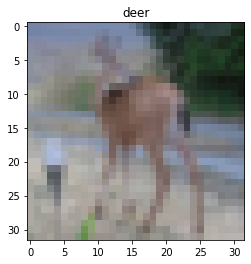

'deer'

In [19]:
index_to_predict = 100
show_image(x_test[index_to_predict], get_test_label(index_to_predict))
predict_image(x_test[index_to_predict])

In [23]:
def visualize_layer_activations(activations):
    images_per_row = 16

    for layer_activation in activations: # Displays the feature maps
        #layer_name = layer_activation.name
        layer_activation = K.eval(layer_activation)
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 2. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        #plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto')
    plt.clf()

/home/h6/s0403431/tf_kernel/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/h6/s0403431/tf_kernel/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.


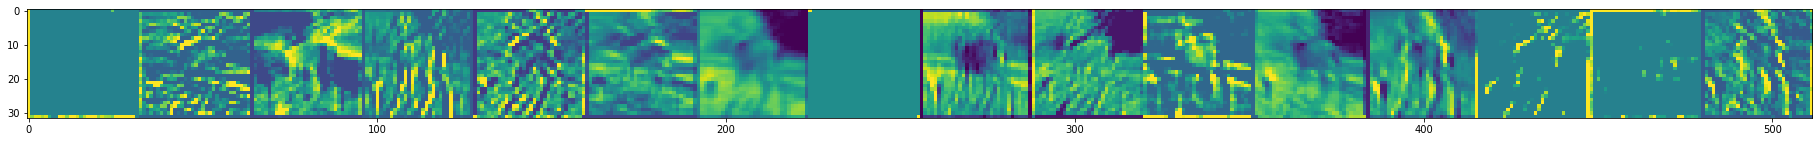

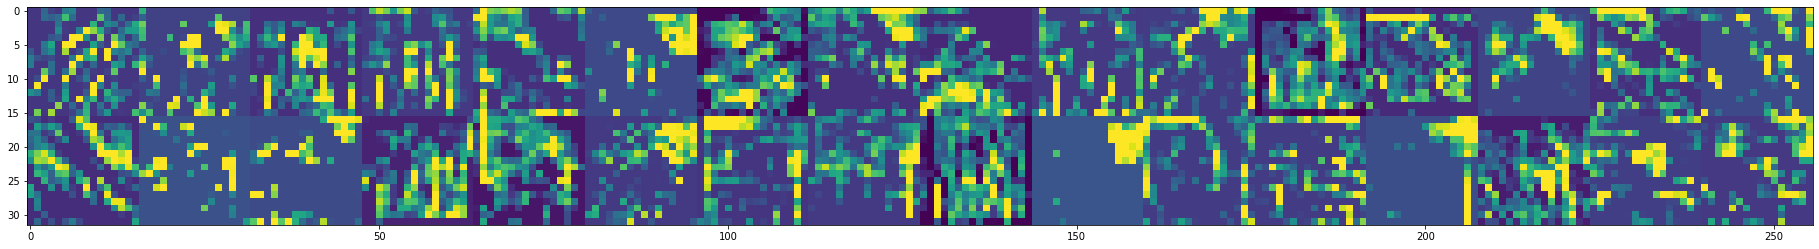

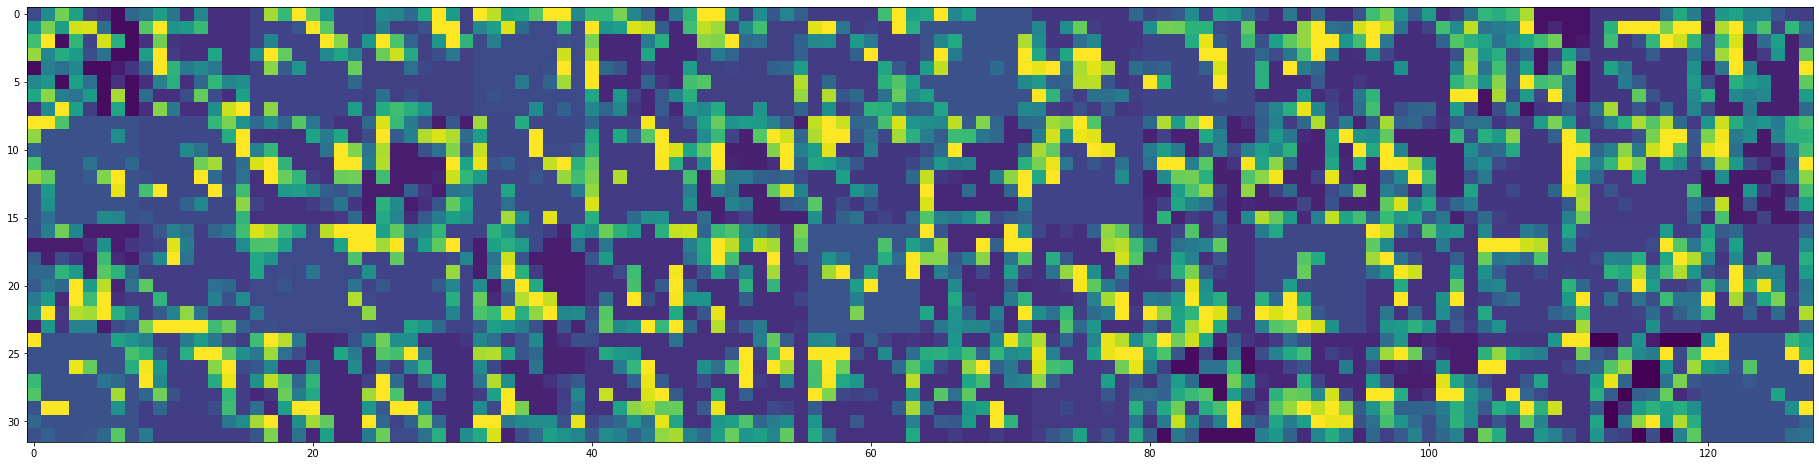

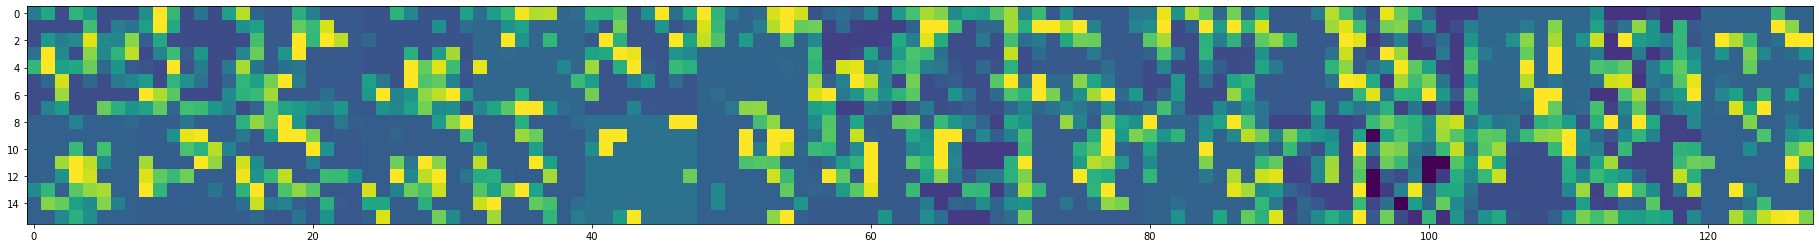

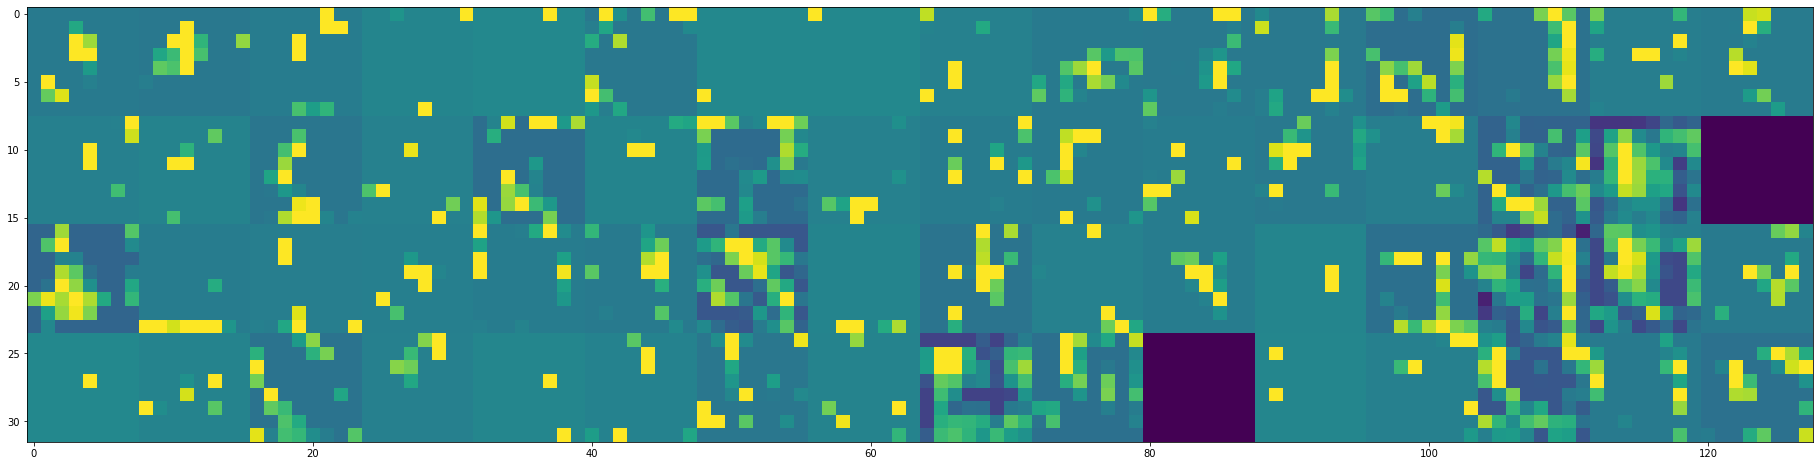

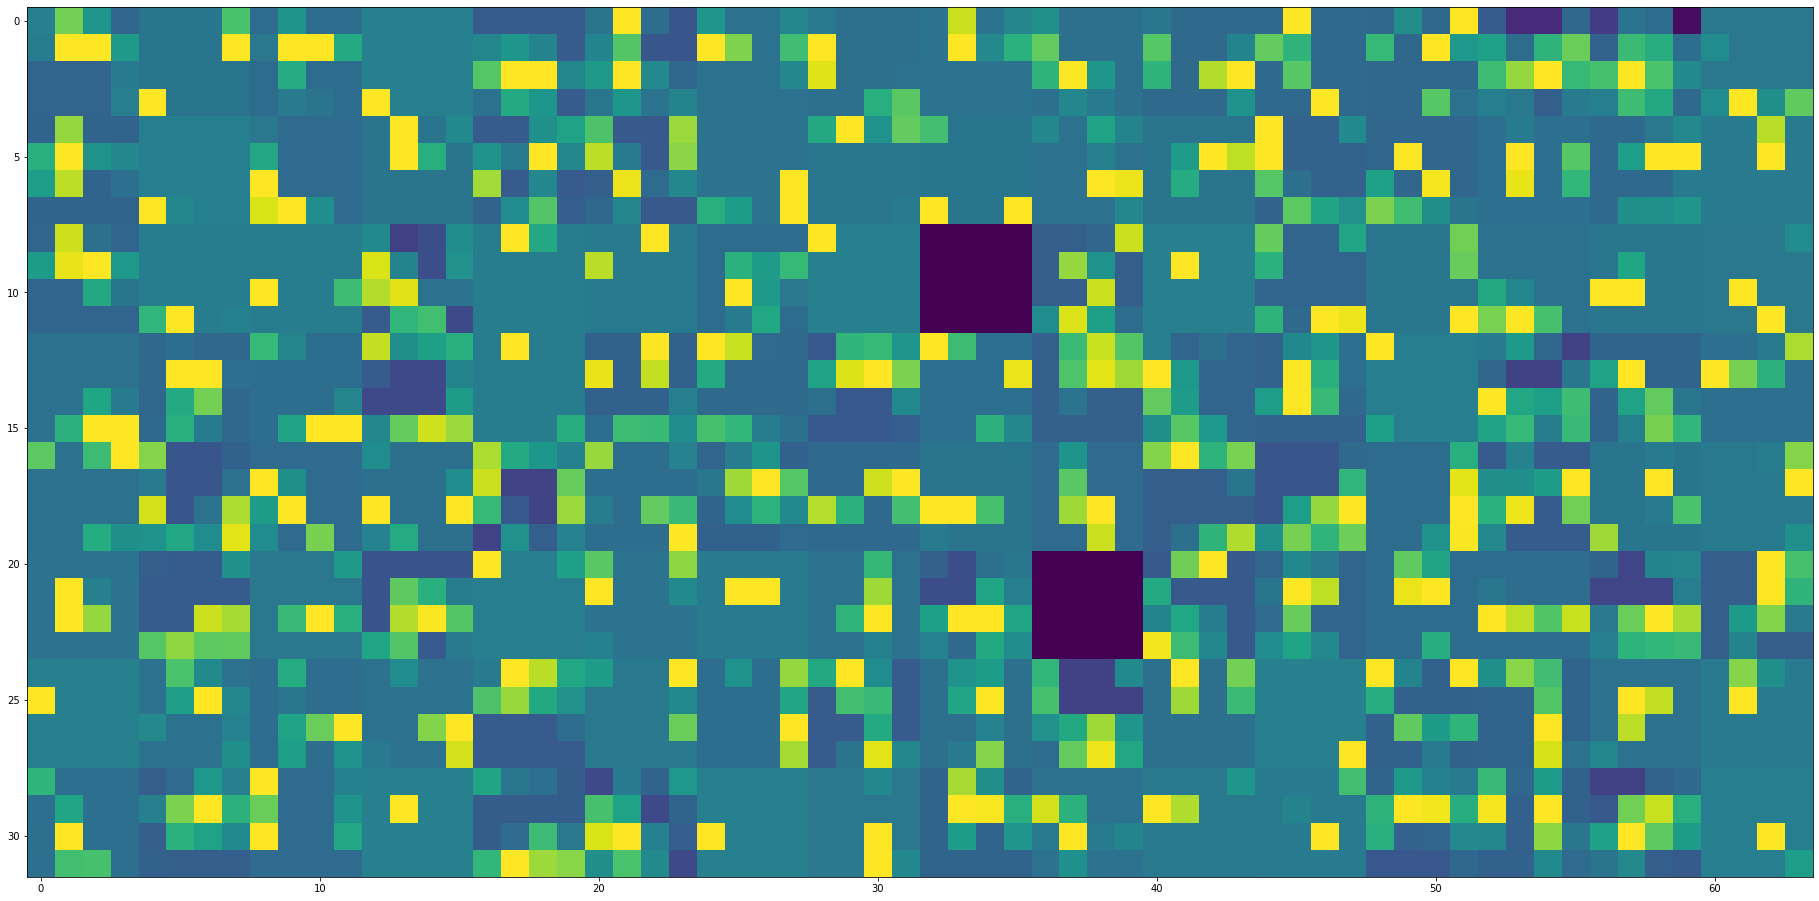

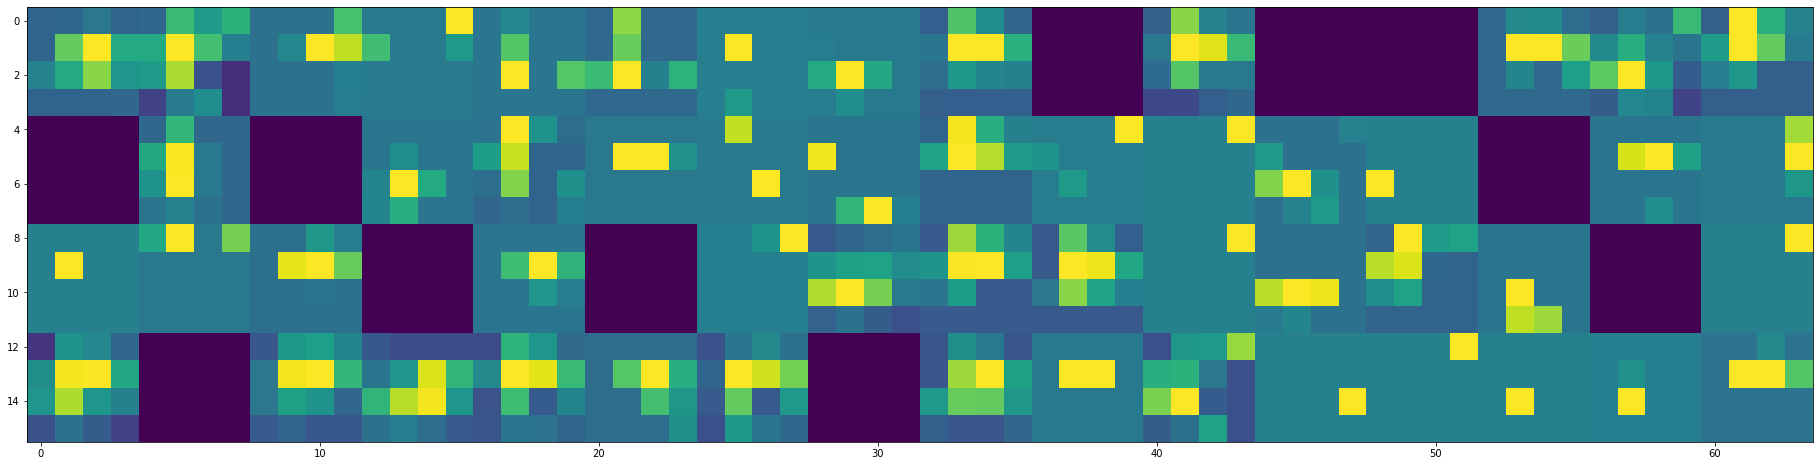

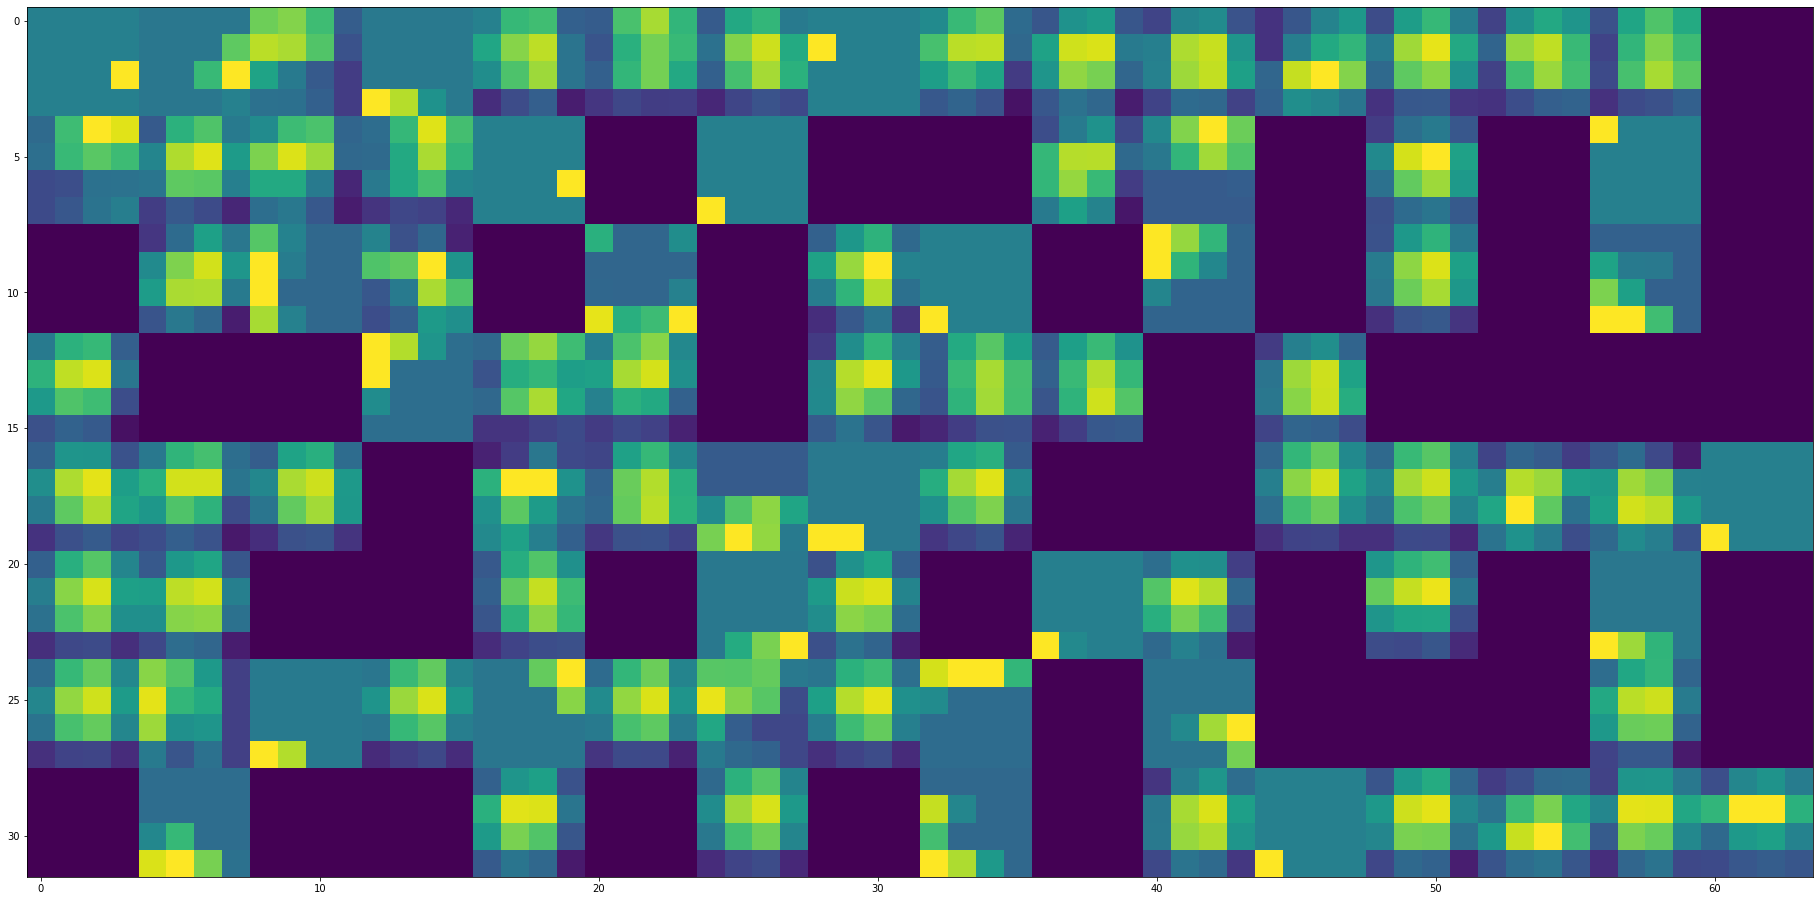

<Figure size 2304x0 with 0 Axes>

In [24]:
layer_activations = extraction_model(x_test[index_to_predict][None, ...])
visualize_layer_activations(layer_activations)

### PLEASE RUN THIS COMMAND IF YOU FINISHED THE NOTEBOOK

In [ ]:
import os
temp=os.getpid()
# !kill -9 $temp